<a href="https://colab.research.google.com/github/stanger-09/audio-classification-project/blob/main/ASIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!pip install librosa

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"uihoij","key":"88dd13769954ea31dd10e52580e3b409"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d aklimarimi/audio-classifier-dataset

Dataset URL: https://www.kaggle.com/datasets/aklimarimi/audio-classifier-dataset
License(s): CC0-1.0
audio-classifier-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# !unzip -o audio-classifier-dataset.zip

In [7]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU mode")


CUDA available: False
GPU name: CPU mode


In [8]:
import zipfile
import os

zip_file_path = 'audio-classifier-dataset.zip'
extract_dir = './audio_data' # Create a directory to extract the audio files

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted data to: {extract_dir}")

Extracted data to: ./audio_data


# ***code***

In [9]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [10]:
DIR='./audio_data'    #path for audio
resample=16000   #resample 16KHZ
sec=5            # seconds to 5
total_dur=resample*sec #total duration 80,000
audio_data=[]

In [11]:
def loadAudio(DIR,resample,sec):
  for dirpath,_,filenames in os.walk(DIR):
    for file in filenames:
      if not file.endswith('.wav'):
        continue
      path=os.path.join(dirpath,file)
      audio,sr=librosa.load(path,sr=resample,mono=True)

      #trim silence
      audio,_=librosa.effects.trim(audio,top_db=20)

      #Normalize
      if(np.max(np.abs(audio))>0):
        audio=audio/np.max(np.abs(audio))

      #crop/padding for 5 sec
      if(len(audio)<total_dur):
        audio=np.pad(audio,(0,total_dur-len(audio)))
      else:
        audio=audio[:total_dur]
      audio_data.append(audio)

In [12]:
#matrix to store
loadAudio(DIR,resample,sec)
print(len(audio_data))

7755


In [13]:
spec=[]
def feature_exe(audio_data):
  n_mels=128
  n_fft=1024
  hop_length=160
  y=16000
  # sr=16000, n_mels=128, n_fft=1024, hop_length=160
  print(len(audio_data) )
  for i in audio_data:
    #compute to Mel Spectrogram
    mel_spectrogram=librosa.feature.melspectrogram(y=i,sr=y,n_mels=n_mels,n_fft=n_fft,hop_length=hop_length)

    # compute to log Mel Spectrogram db
    log_mel_sp.append(librosa.power_to_db(mel_spectrogram,ref=np.max).T)
  # spec.append(log_mel.T)

In [14]:
log_mel_sp=[]
feature_exe(audio_data)
print(len(log_mel_sp))
# audio_data.clear()

7755
7755


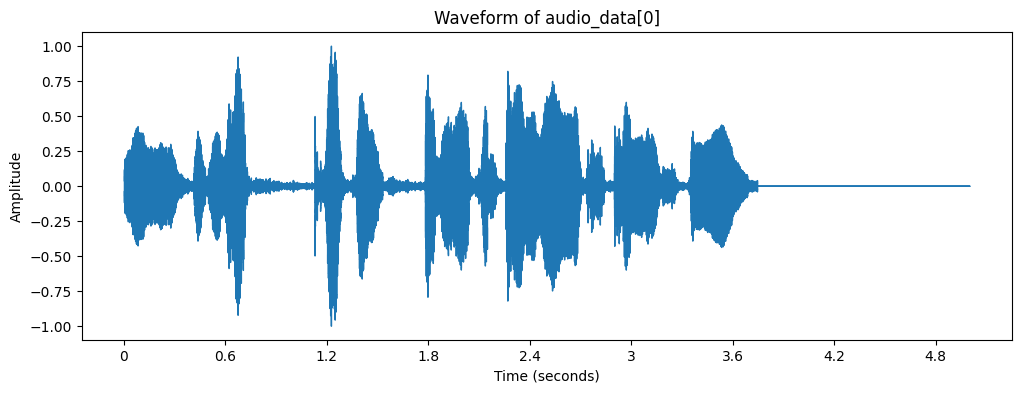

In [15]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data[0], sr=16000)  # use waveshow (librosa>=0.8) or waveplot
plt.title("Waveform of audio_data[0]")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

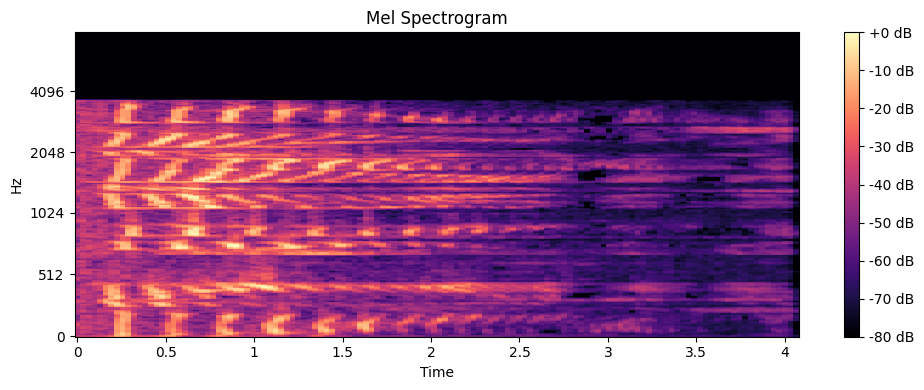

In [16]:
# 3Ô∏è Optional: visualize
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_sp[0], sr=16000, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [17]:
def gmml_mask_spectrogram(feature):
    patch_size=16
    mask_ratio=0.7
    for spec in feature:
      time_dim, freq_dim = spec.shape
      nt, nf = time_dim // patch_size, freq_dim // patch_size
      patch_indices = [(i, j) for i in range(nt) for j in range(nf)]
      np.random.shuffle(patch_indices)
      num_masked = int(len(patch_indices) * mask_ratio)
      masked_spec = np.copy(spec)
      for (i, j) in patch_indices[:num_masked]:
          masked_spec[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0
      gmml.append(masked_spec)

In [18]:
gmml=[]
gmml_mask_spectrogram(log_mel_sp)
print(len(gmml))

7755


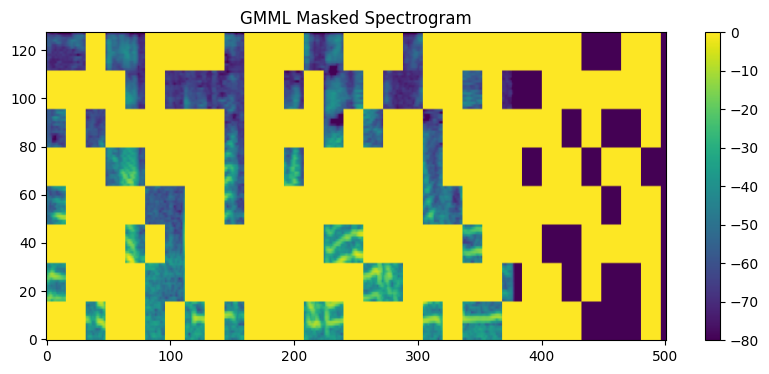

In [19]:
plt.figure(figsize=(10, 4))
plt.imshow(gmml[0].T, aspect='auto', origin='lower')
plt.title('GMML Masked Spectrogram')
plt.colorbar()
plt.show()

# **Teacher-Student model**

In [20]:
audio_data=np.array(audio_data)
log_mel_sp=np.array(log_mel_sp)


In [21]:
import numpy as np
import torch

# Example: both arrays have shape (num_samples, feature_length)
# audio_data: [low-level features]
# log_mel_sp: [high-level features]
audio_tensor = torch.tensor(audio_data, dtype=torch.float32)
logmel_tensor = torch.tensor(log_mel_sp, dtype=torch.float32)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_tensor, logmel_tensor = audio_tensor.to(device), logmel_tensor.to(device)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Encoder: feature extractor
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)          # latent representation
        return z

# -----------------------------
# Decoder: reconstructs input
# -----------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024)
        self.fc2 = nn.Linear(1024, output_dim)

    def forward(self, z):
        x_hat = torch.sigmoid(self.fc2(F.relu(self.fc1(z))))
        return x_hat

# -----------------------------
# Teacher Autoencoder
# -----------------------------
class TeacherAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(TeacherAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

# -----------------------------
# Student Autoencoder
# -----------------------------
class StudentAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(StudentAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


In [23]:
print(logmel_tensor.shape)
print(log_mel_sp.shape)

torch.Size([7755, 501, 128])
(7755, 501, 128)


In [24]:
teacher = TeacherAutoencoder(input_dim=501 * 128, latent_dim=128).to(device)
optimizer = torch.optim.Adam(teacher.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    # Flatten the input tensor before passing it to the teacher model
    flattened_logmel_tensor = logmel_tensor.view(logmel_tensor.size(0), -1)
    recon, z = teacher(flattened_logmel_tensor)

    # Reshape the reconstructed tensor back to the original shape for loss calculation
    recon = recon.view_as(logmel_tensor)
    loss = criterion(recon, logmel_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[Teacher] Epoch {epoch+1} | Reconstruction Loss: {loss.item():.6f}")

[Teacher] Epoch 1 | Reconstruction Loss: 3206.906738
[Teacher] Epoch 2 | Reconstruction Loss: 3172.240967
[Teacher] Epoch 3 | Reconstruction Loss: 3159.303467
[Teacher] Epoch 4 | Reconstruction Loss: 3155.191895
[Teacher] Epoch 5 | Reconstruction Loss: 3153.838623
[Teacher] Epoch 6 | Reconstruction Loss: 3153.441162
[Teacher] Epoch 7 | Reconstruction Loss: 3153.294189
[Teacher] Epoch 8 | Reconstruction Loss: 3153.215332
[Teacher] Epoch 9 | Reconstruction Loss: 3153.198975
[Teacher] Epoch 10 | Reconstruction Loss: 3153.186035


In [25]:
torch.save(teacher.state_dict(), "teacher_autoencoder.pth")


In [36]:
student = StudentAutoencoder(input_dim=80000, latent_dim=128).to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
recon_loss_fn = nn.MSELoss()
distill_loss_fn = nn.MSELoss()

teacher.eval()  # freeze teacher
for param in teacher.parameters():
    param.requires_grad = False

# Lists to store losses for plotting
student_total_losses = []
student_distill_losses = []

for epoch in range(5):
    # Forward passes
    with torch.no_grad():
        flattened_logmel_tensor = logmel_tensor.view(logmel_tensor.size(0), -1)
        _, teacher_z = teacher(flattened_logmel_tensor)   # teacher latent space

    # Flatten the input tensor before passing it to the student model
    flattened_audio_tensor = audio_tensor.view(audio_tensor.size(0), -1)
    student_recon, student_z = student(flattened_audio_tensor)

    # Compute losses
    # Reshape the reconstructed tensor back to the original shape for loss calculation
    student_recon = student_recon.view_as(audio_tensor)
    recon_loss = recon_loss_fn(student_recon, audio_tensor)
    distill_loss = distill_loss_fn(student_z, teacher_z)
    loss = recon_loss + 5.0 * distill_loss   # weighted combination

    # Store losses for plotting
    student_total_losses.append(loss.item())
    student_distill_losses.append(distill_loss.item())


    # Optimize student
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[Student] Epoch {epoch+1} | Total: {loss.item():.6f} | Recon: {recon_loss.item():.6f} | Distill: {distill_loss.item():.6f}")

[Student] Epoch 1 | Total: 3012793600.000000 | Recon: 0.274698 | Distill: 602558720.000000
[Student] Epoch 2 | Total: 3012761344.000000 | Recon: 0.265960 | Distill: 602552256.000000
[Student] Epoch 3 | Total: 3012711680.000000 | Recon: 0.237110 | Distill: 602542336.000000
[Student] Epoch 4 | Total: 3012636672.000000 | Recon: 0.171933 | Distill: 602527360.000000
[Student] Epoch 5 | Total: 3012534272.000000 | Recon: 0.090985 | Distill: 602506880.000000


In [37]:
torch.save(student.state_dict(), "student_autoencoder.pth")


In [38]:
teacher.eval()
student.eval()

# Encode with teacher
flattened_logmel_tensor = logmel_tensor.view(logmel_tensor.size(0), -1)
_, teacher_latent = teacher(flattened_logmel_tensor)

# Encode with student
flattened_audio_tensor = audio_tensor.view(audio_tensor.size(0), -1)
_, student_latent = student(flattened_audio_tensor)

print("Teacher latent shape:", teacher_latent.shape)
print("Student latent shape:", student_latent.shape)

Teacher latent shape: torch.Size([7755, 128])
Student latent shape: torch.Size([7755, 128])


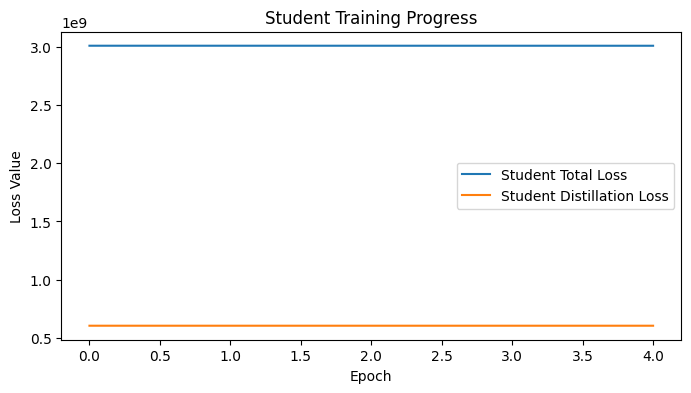

In [39]:
plt.figure(figsize=(8,4))
plt.plot(student_total_losses, label='Student Total Loss')
plt.plot(student_distill_losses, label='Student Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Student Training Progress')
plt.legend()
plt.show()

In [41]:
teacher.eval()
student.eval()

with torch.no_grad():
    # Encode with teacher (using flattened logmel_tensor)
    flattened_logmel_tensor = logmel_tensor.view(logmel_tensor.size(0), -1)
    teacher_latent = teacher.encoder(flattened_logmel_tensor)
    teacher_output = teacher.decoder(teacher_latent).view_as(logmel_tensor) # Reshape back for potential comparison

    # Encode with student (using flattened audio_tensor)
    flattened_audio_tensor = audio_tensor.view(audio_tensor.size(0), -1)
    student_latent = student.encoder(flattened_audio_tensor)
    student_output = student.decoder(student_latent).view_as(audio_tensor) # Reshape back for potential comparison

    # Calculate loss and similarity between latent spaces
    final_loss = F.mse_loss(student_latent, teacher_latent).item()
    final_sim = F.cosine_similarity(student_latent, teacher_latent, dim=1).mean().item()


print(f"üîπ Final Evaluation ‚Üí Latent Space Loss (MSE): {final_loss:.6f} | Latent Space Similarity (Cosine): {final_sim:.4f}")

üîπ Final Evaluation ‚Üí Latent Space Loss (MSE): 602480128.000000 | Latent Space Similarity (Cosine): 0.8326


In [44]:
import gc

del audio_tensor, logmel_tensor
gc.collect()
torch.cuda.empty_cache()
print("üßπ Cleanup done: GPU & CPU memory cleared!")

üßπ Cleanup done: GPU & CPU memory cleared!
